In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

## Load images

In [16]:
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            image = cv2.resize(image, (128,128))
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('dataset')
print('loaded',len(samples),' samples')

labels[labels=='new_cats']='cats'
labels[labels=='new_dogs']='dogs'

print('classes',set(labels))

# normalization
samples = samples / 255.0

loaded 6198  samples
classes {'dogs', 'cats'}


## Show examples

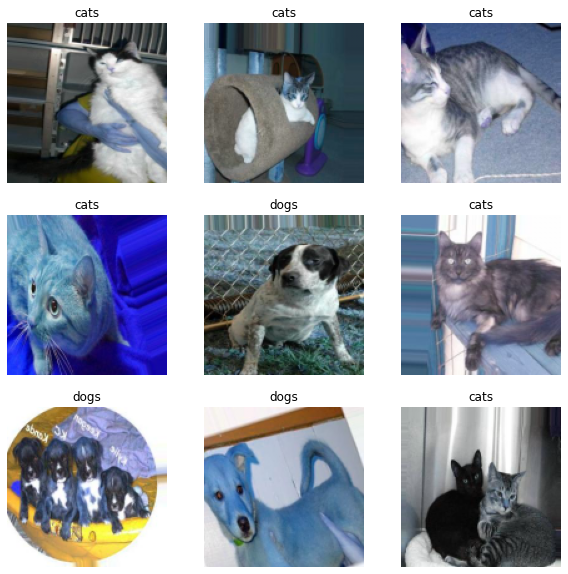

In [17]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10, 10))
for i in range(9):
    n = random.randrange(len(samples))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

## Create a CNN model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(128,128,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("sigmoid"))
model.add(Dense(2))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_10 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_11 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)       

## Prepare labels (one-hot)

In [19]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() # encoder
intlabels = encoder.fit_transform(labels)
labels = tf.keras.utils.to_categorical(intlabels)
print("One-hot labels",labels.shape)

One-hot labels (6198, 2)


## Train model

In [20]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=42)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

checkpt = ModelCheckpoint (filepath='model.h5', save_best_only=True)
estopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

EPOCHS = 100
H = model.fit(trainSamples, trainLabels, epochs=EPOCHS, batch_size=128, validation_data=(testSamples,testLabels),
             callbacks = [estopping,checkpt]) 
print("Done")

(6198, 128, 128, 3)
Epoch 1/100
37/37 [==============================] - 38s 1s/step - loss: 0.7155 - accuracy: 0.5854 - val_loss: 0.6526 - val_accuracy: 0.5684
Epoch 2/100
37/37 [==============================] - 42s 1s/step - loss: 0.5575 - accuracy: 0.7091 - val_loss: 0.5576 - val_accuracy: 0.7523
Epoch 3/100
37/37 [==============================] - 41s 1s/step - loss: 0.4917 - accuracy: 0.7608 - val_loss: 0.5341 - val_accuracy: 0.7155
Epoch 4/100
37/37 [==============================] - 42s 1s/step - loss: 0.3926 - accuracy: 0.8305 - val_loss: 0.4354 - val_accuracy: 0.7981
Epoch 5/100
37/37 [==============================] - 40s 1s/step - loss: 0.3061 - accuracy: 0.8690 - val_loss: 0.3729 - val_accuracy: 0.8445
Epoch 6/100
37/37 [==============================] - 41s 1s/step - loss: 0.2401 - accuracy: 0.9073 - val_loss: 0.3287 - val_accuracy: 0.8561
Epoch 7/100
37/37 [==============================] - 41s 1s/step - loss: 0.1831 - accuracy: 0.9294 - val_loss: 0.3428 - val_accuracy: 

## Show results

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))


[[26  1]
 [23  1]]
              precision    recall  f1-score   support

           0       0.53      0.96      0.68        27
           1       0.50      0.04      0.08        24

    accuracy                           0.53        51
   macro avg       0.52      0.50      0.38        51
weighted avg       0.52      0.53      0.40        51

CNN Accuracy: 0.53
Cohen's Kappa: 0.00


## Loss and accuracy in epochs

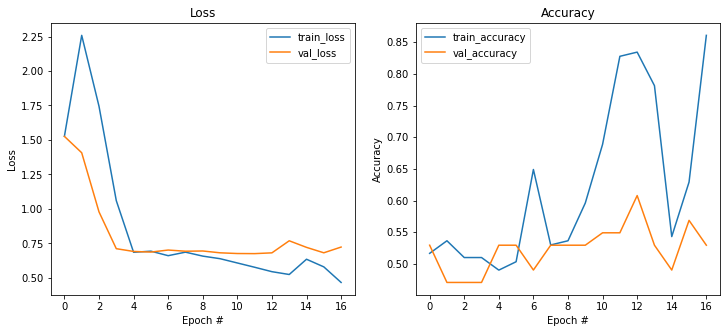

In [15]:
import matplotlib.pyplot as plt
N = np.arange(0, len(H.history["loss"]))

fig,(loss_plot,acc_plot) = plt.subplots(1,2, figsize=(12, 5))

loss_plot.plot(N, H.history["loss"], label="train_loss")
loss_plot.plot(N, H.history["val_loss"], label="val_loss")
loss_plot.set_title("Loss")
loss_plot.set(xlabel='Epoch #', ylabel='Loss')
loss_plot.legend()

acc_plot.plot(N, H.history["accuracy"], label="train_accuracy")
acc_plot.plot(N, H.history["val_accuracy"], label="val_accuracy")
acc_plot.set_title("Accuracy")
acc_plot.set(xlabel='Epoch #', ylabel='Accuracy')
acc_plot.legend()

## kNN/DecisionTree classifier (for comparison)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# flatten samples
flat_samples = samples
flat_samples = np.reshape(flat_samples,newshape=(202,-1))
print("Samples shape flattened",flat_samples.shape)

(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(flat_samples,labels,random_state=42)

# choose classifier
knnmodel = DecisionTreeClassifier()
#knnmodel = KNeighborsClassifier()

# fit model
knnmodel.fit(trainSamples, trainLabels)
knnResults = knnmodel.predict(testSamples)    

# show results
print(confusion_matrix(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
knnAcc = accuracy_score(testLabels.argmax(axis=1), knnResults.argmax(axis=1)) 
print("kNN Accuracy: {:.2f}".format(knnAcc))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), knnResults.argmax(axis=1))))

Samples shape flattened (202, 49152)
[[11 16]
 [15  9]]
              precision    recall  f1-score   support

           0       0.42      0.41      0.42        27
           1       0.36      0.38      0.37        24

    accuracy                           0.39        51
   macro avg       0.39      0.39      0.39        51
weighted avg       0.39      0.39      0.39        51

kNN Accuracy: 0.39
Cohen's Kappa: -0.22


In [ ]:
model.save("final_model.h5")